In [1]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import sklearn.model_selection
import scipy
import sklearn.metrics.pairwise as pw
from time import time
import matplotlib.pyplot as plt

In [2]:
# Specify your directory
DIR = r'C:\Users\Jackie\OneDrive - Georgia Institute of Technology\ISYE6740 Computational Data Analytics\Project\Data\Genres\YoungAdult'

In [3]:
# Load pickled files
df = pd.read_pickle('is_read_and_multiple.pkl')

In [4]:
# The Young Adult genre has the highest interaction / book ratio: 34,919,254 interactions and 93,398 books
#interactions = load_data(os.path.join(DIR, 'goodreads_interactions_young_adult.json.gz'))

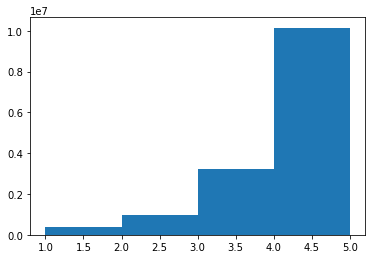

In [5]:
plt.hist(df['rating'], bins=[1,2,3,4,5])
plt.show()

In [6]:
# Calculate average rating
avg_rating = np.mean(df['rating'])
avg_rating

3.919887688450914

In [15]:
df

In [16]:
# mat1 = df.set_index(['user_id', 'book_id'])
# mat2 = mat1['rating']
# mat3 = mat2.unstack('book_id')

In [17]:
# Define user-book rating matrix
mat = df.pivot(index='user_id', columns='book_id', values='rating')
mat.replace(0, np.nan, inplace=True)

IndexError: index 1620130203 is out of bounds for axis 0 with size 1620126425

In [ ]:
mat

In [ ]:
plt.hist(mat.count(), bins=[1,2,3,4,5,6,7,8,9,10])
plt.title("Books with 10 or fewer reviews")
plt.show()

In [ ]:
np.max(mat.count())

In [ ]:
mat.count()[mat.count()==1].index

In [ ]:
mat.count()[mat.count()!=1].index

In [ ]:
# Train/test split
train, test = sklearn.model_selection.train_test_split(is_read_and_multiple_df, test_size=0.1, random_state=1111)
train.shape, test.shape

In [ ]:
# Set all test values to nan
mat_trainonly = mat
zipped_test = np.c_[test['user_id'], test['book_id'], test['rating']]
test_mask = np.full(mat.shape, False)
for i in range(len(zipped_test)):
    row_idx = mat_trainonly.index.get_loc(zipped_test[i][0])
    col_idx = mat_trainonly.columns.get_loc(zipped_test[i][1])
    test_mask[row_idx, col_idx] = True
test_actuals = np.array(mat)[test_mask] # Save test actuals
mat_trainonly[test_mask] = np.nan

In [ ]:
mat_trainonly.at[zipped_test[0][0], zipped_test[0][1]]

In [ ]:
# Calculate sparsity of data
not_null = mat_trainonly.count().sum()
sparsity = 1 - not_null / (mat.shape[0] * mat_trainonly.shape[1])
sparsity

In [ ]:
mat_trainonly.count().sort_values(ascending=False)

In [ ]:
# Number of books with 0 ratings outside of what was in the test set
(mat_trainonly.count()==0).sum()

In [ ]:
# Calculate average rating for each book over users
avg_book_rating = np.nanmean(mat_trainonly, axis=0) # column avg r_j
# For empty columns, fill with avg rating
np.nan_to_num(avg_book_rating, copy=False, nan=avg_rating)

# Fill missing value with the appropriate average for that book
filled = np.where(np.isnan(mat_trainonly), avg_book_rating, mat_trainonly)

In [ ]:
# Remove from each user (row) the mean over all books
avg_user_rating = np.average(filled, axis=1) # row avg r_i
avg_user_rating_col_vec = avg_user_rating.reshape(len(avg_user_rating),1)
normalized = filled - avg_user_rating_col_vec

In [ ]:
normalized

In [ ]:
normalized.shape

In [ ]:
# Perform SVD, decide on a rank k, and calculate a reduced rating matrix to remove noise
# Can use sparse matrix algorithms because of special structure
# How to choose k: if top few values are big and the rest are small, take the big values. So chose k=11
U, S, VT = scipy.sparse.linalg.svds(normalized, k=6) # CHANGE BACK TO k=11

In [ ]:
#U, S, VT = np.linalg.svd(normalized) #k=10

# U = U[:, :9]
# S = S[:9]
# VT = VT[:9, :]

In [ ]:
S

In [ ]:
U.shape, S.shape, VT.shape

In [ ]:
reduced_rating = U @ np.diag(S) @ VT

In [ ]:
reduced_rating # SHOULD THIS BE >=1? Maybe not, because it's already been reduced

In [ ]:
reduced_rating.shape

In [ ]:
# Calculate matrix product for dimensionality-reduced rating matrix
sqrtS = np.diag(np.sqrt(S))
meta_on_users = U @ np.transpose(sqrtS)
meta_on_items = sqrtS @ VT

In [ ]:
meta_on_items

In [ ]:
# # Calculate similarity of 2 books j and f based on the reduced rating matrix
# # Similarity is the correlation of 2 movies based on average over users
# def similarity(j, f, matrix):
#     j_col = matrix[:, j]
#     f_col = matrix[:, f]
#     numerator = np.sum(np.multiply(j_col, f_col))
#     denominator = np.sqrt(np.multiply(np.sum(np.square(j_col)), np.sum(np.square(f_col))))
#     return numerator / denominator

In [ ]:
# num_books = reduced_rating.shape[1]
# t1 = time()
# similarities = np.zeros((num_books, num_books))
# # TODO: is there a faster way to do this?
# for i in range(num_books):
#     for j in range(num_books):
#         similarities[i, j] = similarity(i, j, meta_on_items)
# t2 = time()

In [ ]:
# t2-t1

In [ ]:
# num_books = reduced_rating.shape[1]
# t1 = time()
# col_prods = meta_on_items.T.dot(meta_on_items)

# similarities2 = np.zeros((num_books, num_books))
# # TODO: is there a faster way to do this?
# for i in range(num_books):
#     for j in range(i, num_books):
#         similarities2[i, j] = col_prods[i, j] / np.sqrt(col_prods[i, i] * col_prods[j, j])
#         similarities2[j, i] = similarities2[i, j]
# t2 = time()

In [ ]:
# similarities.shape, t2-t1, np.allclose(similarities, similarities2)

In [ ]:
num_books = reduced_rating.shape[1]
t1 = time()
similarities = pw.cosine_similarity(meta_on_items.T, meta_on_items.T)
t2 = time()

In [ ]:
similarities.shape, t2-t1

In [ ]:
# # Without reducing dimensionality
# num_books = reduced_rating.shape[1]
# t1 = time()
# similarities = pw.cosine_similarity(reduced_rating.T, reduced_rating.T)
# t2 = time()
# similarities.shape, t2-t1

In [ ]:
# # TODO: try optimizing
# # Calculate prediction of rating by user i of book j, by avging over the ratings of all books by the same user, each weighted according to its similarity to book j
# num_users = reduced_rating.shape[0]
# predictions = np.zeros((num_users, num_books))

# # Isolate the set of items which appear to be the most similar to the active item. Vozalis suggests 10 items is best.
# most_similar_idx = np.argsort(similarities, axis=1)[:,-10:]
# for a in range(num_users):
#     for j in range(num_books):
#         numerator = 0
#         denominator = 0
#         # check that similarities are non-negative
#         for k in most_similar_idx[j,:]:
#             sim = similarities[j,k]
#             if sim < 0:
#                 break
#             numerator += sim * (reduced_rating[a,k] + avg_user_rating[a])
#             denominator += sim
#         predictions[a,j] = numerator/denominator

In [ ]:
def rearrange_cols(arr, idx):
    rows = np.indices(idx.shape)[0]
    return arr[rows, idx]

# Calculate prediction of rating by user i of book j, by avging over the ratings of all books by the same user, each weighted according to its similarity to book j
num_users = reduced_rating.shape[0]
predictions = np.zeros((num_users, num_books))

# Isolate the set of items which appear to be the most similar to the active item. Vozalis suggests 10 items is best.
t1 = time()
most_similar_idx = np.argsort(similarities, axis=1)[:,:-11:-1]
adjusted_rating = reduced_rating + avg_user_rating[:,np.newaxis]
nonneg_sims = np.where(similarities > 0, similarities, 0)
sorted_sims = rearrange_cols(nonneg_sims, most_similar_idx)
denominator = np.sum(sorted_sims, axis=1)
for a in range(num_users):
    for j in range(num_books):
        numerator = 0
        for k in most_similar_idx[j,:]:
            numerator += nonneg_sims[j,k] * adjusted_rating[a,k]
        predictions[a,j] = numerator/denominator[j]
t2 = time()
t2-t1

In [ ]:
print(np.min(predictions), np.max(predictions))
predictions

In [ ]:
np.shape(predictions)

In [ ]:
# Define error function
def rmse(predictions, actuals):
    return np.sqrt(((predictions - actuals) ** 2).mean())

In [ ]:
# Calculate training error
training_mask = np.array(mat_trainonly.notna())
train_predictions = predictions[training_mask]
train_actuals = np.array(mat_trainonly)[training_mask]
train_rmse = rmse(train_predictions, train_actuals)
train_rmse

In [ ]:
train_predictions, train_actuals

In [ ]:
# Calculate test error
#zipped_test = np.c_[test['user_id'], test['book_id'], test['rating']]
test_predictions = predictions[test_mask]
test_rmse = rmse(test_predictions, test_actuals)
test_rmse

In [ ]:
test_predictions[:10], test_actuals[:10]

In [ ]:
# Calculate error if just rated everything the avg rating
avg_train = np.full(train_actuals.shape, avg_rating)
avg_train_rmse = rmse(avg_train, train_actuals)
avg_test = np.full(test_actuals.shape, avg_rating)
avg_test_rmse = rmse(avg_test, test_actuals)
avg_train_rmse, avg_test_rmse

# Debugging

In [ ]:
np.argsort(similarities, axis=0)

In [ ]:
testing = np.array([[1,5,8,3,7],[1,2,3,4,5]])
sorted_testing = np.argsort(testing, axis=1)
sorted_testing[:,-2:]

In [ ]:
np.all(predictions < 5), np.all(predictions > 1)

In [ ]:
np.all(reduced_rating < 5), np.all(reduced_rating > 1)

In [ ]:
reduced_rating

In [ ]:
avg_user_rating